In [1]:
import pandas as pd
import gc
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow as tf

In [2]:
ESTOY_EN_KAGGLE = True

In [10]:
config = {
        # Arquitectura
        "lstm_units_1": 64,
        "lstm_units_2": 32,
        "dense_units": 16,
        "dropout_rate": 0.3,

        # Entrenamiento
        "epochs": 150,
        "batch_size": 250,
        "early_stopping_patience": 20,
        "learning_rate": None,  # Si querés usar Adam con tasa específica

        # Regularización
        "l2_lambda": 0.001,

        # Optimizador
        "optimizer": "rmsprop",  # adam, sgd, rmsprop, etc.

        # Preprocesamiento
        "scaler_name": "robust",  # standard o robust

        # Ventana temporal
        "window_size": 3,
        "feature_cols" : ['tn', 'tn_lag1', 
                          #'tn_lag6', 
                          #'tn_lag12', 
                          'tn_diff1', 
                          #'tn_diff6',
                'rolling_mean3', 'rolling_std3', 'rolling_max3', 'rolling_min3','rolling_max6','rolling_min6',"size"],
    }


In [11]:
if ESTOY_EN_KAGGLE:
    df = pd.read_csv("../entregable/datasets/periodo_x_producto_con_target_transformado_con_feature_engineering_201912.csv", sep=',', encoding='utf-8')
else:
    # Cargar de nuevo por claridad
    df = pd.read_csv("../../data/raw/sell-in.csv", sep="\t")

df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Agregación mensual por producto
df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()

# Crear características por producto
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    
    # Crear features con groupby + transform
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    #df["tn_lag6"] = df.groupby("product_id")["tn"].shift(6)
    #df["tn_lag12"] = df.groupby("product_id")["tn"].shift(12)

    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    #df["tn_diff6"] = df["tn"] - df["tn_lag6"]
    df["size"] = df.groupby("product_id")["tn"].transform("size")
    

    df["rolling_mean3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    df["rolling_std3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    
    df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)
del df
gc.collect()
print(df_features.shape)

(31362, 12)


In [12]:
# Último período disponible
ultimo_mes = df_features["periodo"].max()

# Definir los 3 meses anteriores
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')

# Filtrar productos con datos en al menos 3 de esos meses
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]

# Contar cuántos meses tiene cada producto
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()

# Seleccionar productos válidos
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index

# Filtrar el dataframe original
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()
print(df_features.shape)

(25844, 12)


In [13]:
if ESTOY_EN_KAGGLE:
    df_test = df_features[df_features["periodo"] == pd.to_datetime(201912, format="%Y%m")].copy()
    df_features[df_features["periodo"].isin(pd.to_datetime([201911, 201912], format="%Y%m")) ]
else:
    df_test = df_features[df_features["periodo"] == pd.to_datetime(201910, format="%Y%m")].copy()
    df_features[df_features["periodo"].isin(pd.to_datetime([201910, 201911, 201912], format="%Y%m")) ]

In [14]:
# ================================
# 2. SCALING Y VENTANAS TEMPORALES
# ================================

window_size = config["window_size"]
scaler_name = config["scaler_name"]

feature_cols = config["feature_cols"]

# Agrupar por producto
productos = df_features["product_id"].unique()
scalers = {}  # Guardamos los scalers por producto

X, y, productos_list = [], [], []

for producto in productos:
    df_prod = df_features[df_features["product_id"] == producto].copy()

    if len(df_prod) < window_size + 2:
        continue  # No tiene suficientes datos

    # Escalado por producto
    
    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_features = scaler.fit_transform(df_prod[feature_cols])
    scalers[producto] = scaler

    for i in range(window_size, len(df_prod) - 2):
        X.append(scaled_features[i - window_size:i])  # (window_size, n_features)
        y.append(scaled_features[i + 2][0])  ###### Target: tn escalado en t+2
        productos_list.append(producto)

X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [15]:

# ================================
# 3. TRAIN / TEST SPLIT
# ================================
from sklearn.model_selection import train_test_split

# productos_train, productos_test = train_test_split(np.unique(productos_list), test_size=0.2, random_state=42)

# train_mask = [p in productos_train for p in productos_list]
# test_mask = [p in productos_test for p in productos_list]

# X_train, X_test = X[train_mask], X[test_mask]
# y_train, y_test = y[train_mask], y[test_mask]

# Primero reconstruimos la lista de periodos asociados a cada muestra
periodos = []

for producto in productos:
    df_prod = df_features[df_features["product_id"] == producto].copy()

    if len(df_prod) < window_size + 2:
        continue

    for i in range(window_size, len(df_prod) - 2):
        # El periodo objetivo (de y) es en t+2, entonces corresponde a:
        periodo_target = df_prod.iloc[i + 2]["periodo"]
        periodos.append(periodo_target)

# Convertimos a numpy para facilitar indexado
periodos = np.array(periodos)

# Definimos el umbral de corte (por ejemplo, predecimos diciembre 2019)
fecha_corte = pd.to_datetime("2019-12-01")

# Creamos máscaras según el periodo de y
train_mask = periodos < fecha_corte
test_mask = periodos == fecha_corte  # opcional: podrías usar > fecha_corte para más test

# Aplicamos la máscara
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
productos_test = np.array(productos_list)[test_mask]

In [16]:

# ================================
# 4. MODELO LSTM
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import random
from tensorflow.keras.optimizers import Adam, RMSprop



# Configuración y semillas
semillas = [42, 101, 202, 303, 404]  # Tus semillas
l2_lambda = config["l2_lambda"]
optimizer_name = config["optimizer"]
epochs = config["epochs"]
batch_size = config["batch_size"]
early_stopping_patience = config["early_stopping_patience"]

# Función para crear modelo (con semilla como parámetro)
def crear_modelo(semilla, window_size, n_features):
    tf.keras.utils.set_random_seed(semilla)  # Fija semilla para TensorFlow
    
    model = Sequential([
        LSTM(200, activation='tanh', return_sequences=True, 
             input_shape=(window_size, n_features),
             kernel_regularizer=l2(l2_lambda) if l2_lambda > 0 else None),
        Dropout(0.2, seed=semilla),
        LSTM(32, activation='tanh'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    # Configurar optimizer con semilla
    if optimizer_name.lower() == 'adam':
        optimizer = Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=0.001)
    else:
        optimizer = optimizer_name
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Entrenamiento con semillerio
def entrenar_con_semillerio(X_train, y_train, X_test, y_test):
    modelos = []
    historiales = []
    window_size = X_train.shape[1]
    n_features = X_train.shape[2]
    
    callbacks = [
        EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.1, patience=15)
    ]
    
    for i, semilla in enumerate(semillas):
        print(f"\nEntrenando modelo con semilla {semilla} ({i+1}/{len(semillas)})")
        
        model = crear_modelo(semilla, window_size, n_features)
        
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        modelos.append(model)
        historiales.append(history)
    
    return modelos, historiales



modelos, historiales = entrenar_con_semillerio(X_train, y_train, X_test, y_test)



Entrenando modelo con semilla 42 (1/5)


c:\Users\Usuario\.conda\envs\py311lab3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.6102 - mae: 0.5757 - val_loss: 0.8219 - val_mae: 0.7381 - learning_rate: 0.0010
Epoch 2/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5858 - mae: 0.5660 - val_loss: 0.7998 - val_mae: 0.7252 - learning_rate: 0.0010
Epoch 3/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.5770 - mae: 0.5622 - val_loss: 0.7867 - val_mae: 0.7174 - learning_rate: 0.0010
Epoch 4/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5726 - mae: 0.5606 - val_loss: 0.7841 - val_mae: 0.7163 - learning_rate: 0.0010
Epoch 5/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5686 - mae: 0.5592 - val_loss: 0.7762 - val_mae: 0.7119 - learning_rate: 0.0010
Epoch 6/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5672 - mae: 0.5587 - val_loss: 0.8043 - val_mae: 0.7272 - learning_rate: 0.0010
Epoch 7/150
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5655 - mae: 0.5578 - val_loss: 0.7961 - val_mae: 0.7228 - learning_rate: 0.0010
Epoch 

In [ ]:
# # ================================
# # 5. PREDICCIÓN t+2
# # ================================

# def predecir_t2(product_id, df_features_full):
#     """
#     product_id: ID del producto a predecir.
#     df_features_full: dataframe con las features ya procesadas.
#     """
#     df_prod = df_features_full[df_features_full["product_id"] == product_id].copy()
#     scaler = scalers[product_id]

#     ultimos = df_prod[feature_cols].iloc[-window_size:]
#     ultimos_scaled = scaler.transform(ultimos)

#     X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
#     y_pred_scaled = model.predict(X_new)

#     # Inversión del escalado solo sobre la primera columna (tn)
#     tn_mean = scaler.center_[0]
#     tn_std = scaler.scale_[0]

#     y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
#     return y_pred

In [17]:
# # ================================
# # 5. PREDICCIÓN t+2
# # ================================

def predecir_todos_t2_semillerio(df_features_full, modelos, scalers, feature_cols, window_size):
    """
    Predice tn en t+2 para todos los productos usando un ensemble de modelos con semillerio.

    Args:
        df_features_full (pd.DataFrame): dataframe completo con features
        modelos (list): lista de modelos LSTM entrenados con diferentes semillas
        scalers (dict): diccionario con los StandardScaler por producto
        feature_cols (list): lista de columnas de features
        window_size (int): tamaño de la ventana temporal

    Returns:
        pd.DataFrame: dataframe con columnas ["product_id", "tn_t2_pred"]
    """
    productos = df_features_full["product_id"].unique()
    resultados = []

    for pid in productos:
        df_prod = df_features_full[df_features_full["product_id"] == pid]
        
        if len(df_prod) < window_size:
            continue  # no hay suficientes datos

        try:
            # Preparar datos
            ultimos = df_prod[feature_cols].iloc[-window_size:]
            scaler = scalers[pid]
            ultimos_scaled = scaler.transform(ultimos)
            X_new = ultimos_scaled.reshape(1, window_size, len(feature_cols))
            
            # Predecir con todos los modelos y promediar
            predicciones = []
            for model in modelos:
                y_pred_scaled = model.predict(X_new, verbose=0)
                tn_mean = scaler.center_[0]
                tn_std = scaler.scale_[0]
                y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
                predicciones.append(y_pred)
            
            y_pred_final = np.mean(predicciones)
            
            # Opcional: eliminar outliers extremos antes de promediar
            # y_pred_final = np.mean(np.clip(predicciones, 
            #                           np.percentile(predicciones, 10),
            #                           np.percentile(predicciones, 90)))

        except Exception as e:
            print(f"Error al predecir producto {pid}: {e}")
            y_pred_final = np.mean(df_prod["tn"])  # Valor por defecto si falla
            
        # Asegurar predicción positiva
        y_pred_final = max(0, y_pred_final)
        resultados.append({"product_id": pid, "tn_t2_pred": y_pred_final})

    return pd.DataFrame(resultados)

In [18]:
df_preds_t2 = predecir_todos_t2_semillerio(
    df_features,
    modelos,
    scalers,
    feature_cols,
    window_size
)

print(df_preds_t2.head())

Error al predecir producto 20127: np.int64(20127)
Error al predecir producto 20210: np.int64(20210)
Error al predecir producto 20686: np.int64(20686)
Error al predecir producto 20703: np.int64(20703)
Error al predecir producto 20962: np.int64(20962)
Error al predecir producto 20975: np.int64(20975)
Error al predecir producto 20995: np.int64(20995)
Error al predecir producto 21087: np.int64(21087)
Error al predecir producto 21214: np.int64(21214)
   product_id   tn_t2_pred
0       20001  1368.557567
1       20002  1061.426158
2       20003   798.040597
3       20004   597.680743
4       20005   572.593556


In [ ]:
# df_preds_t2 = predecir_todos_t2(
#     df_features_full=df_features,
#     model=model,
#     scalers=scalers,
#     feature_cols=feature_cols,
#     window_size=window_size
# )

# print(df_preds_t2.head())

Error al predecir producto 20127: np.int64(20127)
Error al predecir producto 20210: np.int64(20210)
Error al predecir producto 20686: np.int64(20686)
Error al predecir producto 20703: np.int64(20703)
Error al predecir producto 20962: np.int64(20962)
Error al predecir producto 20975: np.int64(20975)
Error al predecir producto 20995: np.int64(20995)
Error al predecir producto 21087: np.int64(21087)
Error al predecir producto 21214: np.int64(21214)
   product_id   tn_t2_pred
0       20001  1386.858321
1       20002  1049.577596
2       20003   805.068777
3       20004   594.459138
4       20005   567.989714


In [19]:
df_preds_t2

,product_id,tn_t2_pred
0,20001,1368.557567
1,20002,1061.426158
2,20003,798.040597
3,20004,597.680743
4,20005,572.593556
...,...,...
893,21265,0.053078
894,21266,0.055428
895,21267,0.059385
896,21271,0.013538


In [20]:
df_final = df_test.merge(df_preds_t2, on="product_id", how="left")
df_final

,product_id,periodo,tn,tn_lag1,tn_diff1,size,rolling_mean3,rolling_std3,rolling_max3,rolling_min3,rolling_max6,rolling_min6,tn_t2_pred
0,20001,2019-12-01,1504.68856,1397.37231,107.31625,36,1539.627813,132.676441,1660.00561,1397.37231,1678.99318,1109.93769,1368.557567
1,20002,2019-12-01,1087.30855,1423.57739,-336.26884,36,1497.767150,449.292044,1979.53635,1090.18771,1979.53635,813.78215,1061.426158
2,20003,2019-12-01,892.50129,948.29393,-55.79264,36,999.143847,71.869729,1081.36645,948.29393,1081.36645,635.59563,798.040597
3,20004,2019-12-01,637.90002,723.94206,-86.04204,36,858.269930,181.458030,1064.69633,723.94206,1064.69633,482.13372,597.680743
4,20005,2019-12-01,593.24443,606.91173,-13.66730,36,827.740853,200.028225,996.78275,606.91173,996.78275,536.66800,572.593556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,21265,2019-12-01,0.05007,0.06600,-0.01593,10,0.064093,0.046100,0.10921,0.01707,0.10921,0.01593,0.053078
876,21266,2019-12-01,0.05121,0.06713,-0.01592,10,0.071293,0.045079,0.11831,0.02844,0.11831,0.01480,0.055428
877,21267,2019-12-01,0.01569,0.04052,-0.02483,10,0.051860,0.040441,0.09676,0.01830,0.09676,0.01830,0.059385
878,21271,2019-12-01,0.00298,0.01301,-0.01003,30,0.022290,0.008387,0.02933,0.01301,0.02933,0.00445,0.013538


In [22]:
df_final_copy = df_final.copy()
df_final_copy = df_final_copy[['product_id', 'tn_t2_pred']].rename(columns={'tn_t2_pred': 'tn'})

In [25]:
productos = pd.read_csv("../../data/raw/product_id_apredecir201912.csv", sep=',', encoding='utf-8')
productos

,product_id
0,20001
1,20002
2,20003
3,20004
4,20005
...,...
775,21263
776,21265
777,21266
778,21267


In [26]:
df_final_copy = df_final_copy[df_final_copy["product_id"].isin(productos["product_id"].unique())].copy()
df_final_copy

,product_id,tn
0,20001,1368.557567
1,20002,1061.426158
2,20003,798.040597
3,20004,597.680743
4,20005,572.593556
...,...,...
873,21263,0.021371
875,21265,0.053078
876,21266,0.055428
877,21267,0.059385


In [27]:
df_final_copy.to_csv("./outputs/predicciones_lstm_kaggle.csv", index=False, sep=',')

In [37]:
numerador = (df_final["tn"]- df_final["tn_t2_pred"]).abs().sum()
denominador = df_final["tn"].sum()
porcentaje_error = (numerador / denominador)
porcentaje_error

np.float64(0.2617732191017372)

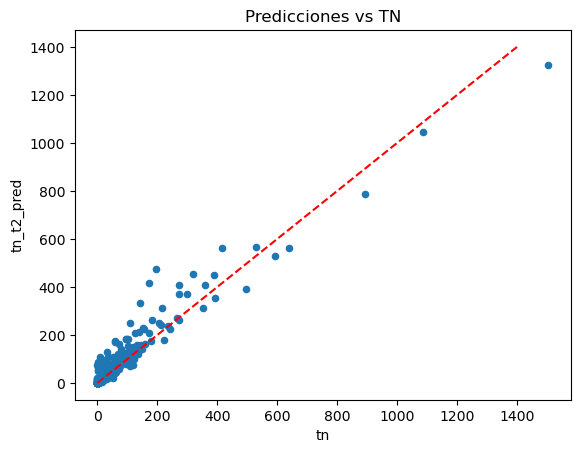

In [168]:
import matplotlib.pyplot as plt
df_final.plot(kind="scatter", x="tn", y="tn_t2_pred", title="Predicciones vs TN")
plt.plot([0, 1400], [0, 1400], 'r--')
plt.show()

In [176]:
import plotly.graph_objects as go

# Crear el gráfico de dispersión
fig = go.Figure()

# Añadir los puntos de dispersión con el product_id en el hover
fig.add_trace(go.Scatter(
    x=df_final["tn"],
    y=df_final["tn_t2_pred"],
    mode='markers',
    name='Datos',
    customdata=df_final["product_id"],  # Pasamos el product_id como dato adicional
    hovertemplate=(
        "<b>TN Real</b>: %{x}<br>"
        "<b>TN Predicho</b>: %{y}<br>"
        "<b>Product ID</b>: %{customdata}<br>"
        "<extra></extra>"  # Elimina información adicional automática
    ),
    marker=dict(size=8, opacity=0.7)  # Opcional: ajustar tamaño y transparencia
))

# Añadir la línea de referencia y=x
fig.add_trace(go.Scatter(
    x=[0, 1400],
    y=[0, 1400],
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

# Configurar el diseño del gráfico para que sea cuadrado
fig.update_layout(
    title='Predicciones vs TN',
    xaxis_title='TN Real',
    yaxis_title='TN Predicho',
    showlegend=True,
    # Forzar misma escala en ejes X e Y
    xaxis=dict(scaleanchor="y", scaleratio=1),
    yaxis=dict(scaleanchor="x", scaleratio=1),
    # Tamaño cuadrado (opcional)
    width=600,
    height=600,
    # Rango fijo para ambos ejes (opcional)
    xaxis_range=[0, 50],
    yaxis_range=[0, 50]
)

# Mostrar el gráfico
fig.show()

In [170]:
print(df_final["tn_t2_pred"].sum(),"|",df_final["tn"].sum())

32015.00363455506 | 25987.52668


In [171]:
df_final["error"] = (df_final["tn"] - df_final["tn_t2_pred"]).abs()
df_final["error_relativo"] = df_final["error"] / df_final["tn"]
df_final.sort_values(by="error", ascending=False, inplace=True)
df_final[["product_id" ,"tn", "tn_t2_pred", "error", "error_relativo"]].head(20)


,product_id,tn,tn_t2_pred,error,error_relativo
7,20008,195.36854,476.125315,280.756775,1.437062
11,20012,173.13004,416.963649,243.833609,1.408384
17,20018,141.63570,331.111573,189.475873,1.337769
0,20001,1504.68856,1322.727699,181.960861,0.120929
5,20006,417.23228,561.699207,144.466927,0.346251
27,20028,109.92618,247.659092,137.732912,1.252958
13,20014,272.02812,408.512577,136.484457,0.501729
12,20013,318.09141,453.887662,135.796252,0.426910
44,20048,58.89241,175.996790,117.104380,1.988446
40,20044,59.61747,169.484635,109.867165,1.842869


In [172]:
sellin = pd.read_csv("../datasets/sell-in.txt.gz", sep="\t")

C:\Users\carre\AppData\Local\Temp\ipykernel_11172\804960764.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



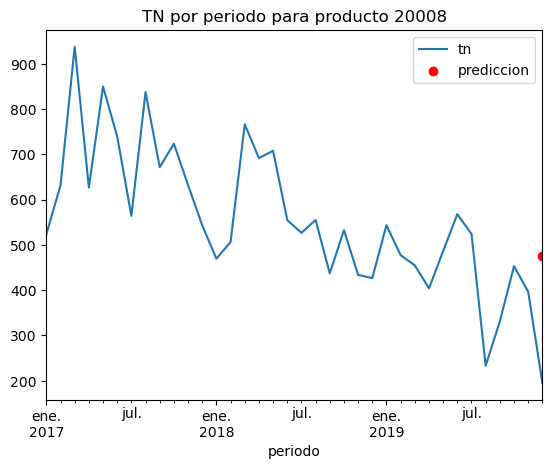

In [173]:

prod = 20008
prod_s = sellin[sellin["product_id"] == prod]
prod_s["periodo"] = pd.to_datetime(prod_s["periodo"], format='%Y%m')
prod_s = prod_s.groupby("periodo").agg({"tn": "sum"}).reset_index()
#prod_s.plot(kind="line", x="periodo", y="tn", title="TN por periodo para producto 20002")

import matplotlib.pyplot as plt

ax = plt.gca()
prod_s.plot(kind="line", x="periodo", y="tn", title=f"TN por periodo para producto {prod}", ax=ax)
#plt.axhline(y=813.82, color='red', linestyle='--', label='predict')
prediccion = df_final[df_final["product_id"] == prod]["tn_t2_pred"].values[0]
plt.scatter(prod_s["periodo"].iloc[-1], prediccion, color='red', label='prediccion')
plt.legend()
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# Configuración
config = {
    "lstm_units_1": 64,
    "lstm_units_2": 32,
    "dense_units": 16,
    "dropout_rate": 0.3,
    "epochs": 150,
    "batch_size": 250,
    "early_stopping_patience": 20,
    "learning_rate": None,
    "l2_lambda": 0.001,
    "optimizer": "rmsprop",
    "scaler_name": "robust",
    "window_size": 3,
    "feature_cols": ['tn', 'tn_lag1', 'tn_diff1', 'rolling_mean3', 
                   'rolling_std3', 'rolling_max3', 'rolling_min3',
                   'rolling_max6', 'rolling_min6', "size"],
}

# Cargar datos
print("Cargando datos...")
df = pd.read_csv("../entregable/datasets/periodo_x_producto_con_target_transformado_con_feature_engineering_201912.csv", 
                 sep=',', encoding='utf-8')
df["periodo"] = pd.to_datetime(df["periodo"], format="%Y%m")

# Agregación mensual por producto
print("Procesando datos...")
df = df.groupby(["product_id", "periodo"]).agg({"tn": "sum"}).sort_values(["product_id", "periodo"]).reset_index()

# Función para crear features
def agregar_features(df):
    df = df.copy()
    df = df.sort_values(["product_id", "periodo"])
    
    df["tn_lag1"] = df.groupby("product_id")["tn"].shift(1)
    df["tn_diff1"] = df["tn"] - df["tn_lag1"]
    df["size"] = df.groupby("product_id")["tn"].transform("size")
    
    df["rolling_mean3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).mean())
    df["rolling_std3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).std())
    df["rolling_max3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).max())
    df["rolling_min3"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(3).min())
    df["rolling_max6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).max())
    df["rolling_min6"] = df.groupby("product_id")["tn"].transform(lambda x: x.shift(1).rolling(6).min())

    return df

df_features = agregar_features(df).fillna(0)

# Filtrar productos con suficiente historial
print("Filtrando productos...")
ultimo_mes = pd.to_datetime("201910", format="%Y%m")  # Octubre 2019
ultimos_3_meses = pd.date_range(end=ultimo_mes - pd.DateOffset(months=1), periods=3, freq='MS')
df_filtrado = df_features[df_features["periodo"].isin(ultimos_3_meses)]
conteo_por_producto = df_filtrado[df_filtrado["tn"] > 0].groupby("product_id").size()
productos_validos = conteo_por_producto[conteo_por_producto >= 3].index
df_features = df_features[df_features["product_id"].isin(productos_validos)].copy()

# Definir períodos
fecha_inicio_train = pd.to_datetime("201901", format="%Y%m")
fecha_fin_train = pd.to_datetime("201910", format="%Y%m")
fecha_prediccion = pd.to_datetime("201912", format="%Y%m")

# Preparar datos de entrenamiento
print("Preparando datos de entrenamiento...")
window_size = config["window_size"]
scaler_name = config["scaler_name"]
feature_cols = config["feature_cols"]
scalers = {}

X_train, y_train = [], []
periodos_train = []

for producto in productos_validos:
    df_prod = df_features[(df_features["product_id"] == producto) & 
                         (df_features["periodo"] <= fecha_fin_train)].copy()
    
    if len(df_prod) < window_size + 2:
        continue
        
    scaler = StandardScaler() if scaler_name == "standard" else RobustScaler()
    scaled_features = scaler.fit_transform(df_prod[feature_cols])
    scalers[producto] = scaler
    
    for i in range(window_size, len(df_prod) - 2):
        periodo_target = df_prod.iloc[i + 2]["periodo"]
        if periodo_target <= fecha_fin_train:
            X_train.append(scaled_features[i - window_size:i])
            y_train.append(scaled_features[i + 2][0])
            periodos_train.append(periodo_target)

if len(X_train) == 0:
    raise ValueError("No hay suficientes datos para entrenamiento. Revisa los filtros.")

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)

# Preparar datos para predicción
print("Preparando datos para predicción...")
X_predict = []
productos_predict = []

for producto in productos_validos:
    df_prod = df_features[df_features["product_id"] == producto].copy()
    
    # Encontrar índice de octubre 2019
    idx_octubre = df_prod[df_prod["periodo"] == fecha_fin_train].index
    if len(idx_octubre) == 0:
        continue
    
    idx_octubre = idx_octubre[0]
    
    # Verificar que tenga suficiente historia antes de octubre
    if idx_octubre < window_size - 1:
        continue
    
    # Obtener ventana temporal (agosto, septiembre, octubre 2019)
    ventana = df_prod.iloc[idx_octubre - window_size + 1:idx_octubre + 1]
    if len(ventana) != window_size:
        continue
    
    # Escalar datos
    scaler = scalers.get(producto)
    if scaler is None:
        continue
    
    try:
        ultimos = ventana[feature_cols]
        ultimos_scaled = scaler.transform(ultimos)
        X_predict.append(ultimos_scaled)
        productos_predict.append(producto)
    except Exception as e:
        print(f"Error procesando producto {producto}: {str(e)}")
        continue

if len(X_predict) == 0:
    raise ValueError("No hay productos válidos para predicción.")
    
X_predict = np.array(X_predict)

# Crear modelo
def crear_modelo(semilla, window_size, n_features):
    tf.keras.utils.set_random_seed(semilla)
    
    model = Sequential([
        LSTM(200, activation='tanh', return_sequences=True, 
             input_shape=(window_size, n_features),
             kernel_regularizer=l2(config["l2_lambda"]) if config["l2_lambda"] > 0 else None),
        Dropout(0.2, seed=semilla),
        LSTM(32, activation='tanh'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    if config["optimizer"].lower() == 'adam':
        optimizer = Adam(learning_rate=0.001)
    elif config["optimizer"].lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=0.001)
    else:
        optimizer = config["optimizer"]
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Entrenamiento
print("Entrenando modelos...")
semillas = [42, 101, 202, 303, 404]
modelos = []

for semilla in semillas:
    print(f"\nEntrenando modelo con semilla {semilla}")
    model = crear_modelo(semilla, X_train.shape[1], X_train.shape[2])
    
    history = model.fit(
        X_train, y_train,
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        validation_split=0.2,
        callbacks=[
            EarlyStopping(patience=config["early_stopping_patience"], restore_best_weights=True),
            ReduceLROnPlateau(factor=0.1, patience=15)
        ],
        verbose=1
    )
    modelos.append(model)

# Predicción
print("\nRealizando predicciones...")
predicciones = []

for i, producto in enumerate(productos_predict):
    scaler = scalers[producto]
    preds_producto = []
    
    for modelo in modelos:
        y_pred_scaled = modelo.predict(X_predict[i:i+1], verbose=0)
        tn_mean = scaler.center_[0]
        tn_std = scaler.scale_[0]
        y_pred = y_pred_scaled[0][0] * tn_std + tn_mean
        preds_producto.append(max(0, y_pred))  # Asegurar valor positivo
    
    # Promedio de las predicciones de todos los modelos
    prediccion_final = np.mean(preds_producto)
    
    predicciones.append({
        "product_id": producto,
        "periodo_real": fecha_prediccion,
        "prediccion_t+2": prediccion_final
    })

df_predicciones = pd.DataFrame(predicciones)

# Obtener valores reales para comparación
df_real = df_features[df_features["periodo"] == fecha_prediccion][["product_id", "tn"]]
df_resultados = df_predicciones.merge(df_real, on="product_id", how="left")

# Calcular métricas
if not df_resultados.empty:
    df_resultados["error"] = abs(df_resultados["tn"] - df_resultados["prediccion_t+2"])
    mae = df_resultados["error"].mean()
    mape = (df_resultados["error"] / df_resultados["tn"]).mean() * 100
    
    print("\nResultados:")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("\nEjemplo de predicciones:")
    print(df_resultados.head())
else:
    print("\nNo hay datos reales para comparación en el período predicho.")

print("\nProceso completado exitosamente!")

Cargando datos...
Procesando datos...
Filtrando productos...
Preparando datos de entrenamiento...
Preparando datos para predicción...
Entrenando modelos...

Entrenando modelo con semilla 42


c:\Users\Usuario\.conda\envs\py311lab3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.6083 - mae: 0.5790 - val_loss: 0.6874 - val_mae: 0.5627 - learning_rate: 0.0010
Epoch 2/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.5812 - mae: 0.5653 - val_loss: 0.6742 - val_mae: 0.5577 - learning_rate: 0.0010
Epoch 3/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5725 - mae: 0.5614 - val_loss: 0.6697 - val_mae: 0.5565 - learning_rate: 0.0010
Epoch 4/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.5674 - mae: 0.5593 - val_loss: 0.6673 - val_mae: 0.5557 - learning_rate: 0.0010
Epoch 5/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.5645 - mae: 0.5580 - val_loss: 0.6688 - val_mae: 0.5560 - learning_rate: 0.0010
Epoch 6/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5623 - mae: 0.5571 - val_loss: 0.6701 - val_mae: 0.5563 - learning_rate: 0.0010
Epoch 7/150
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5598 - mae: 0.5561 - val_loss: 0.6714 - val_mae: 0.5558 - learning_rate: 0.0010
Epoch

In [9]:
df_resultados

,product_id,periodo_real,prediccion_t+2,tn,error
0,20001,2019-12-01,1376.673116,1504.68856,128.015444
